# 正则化 --- 使用Gluon

本章介绍如何使用``Gluon``的正则化来应对[过拟合]()问题。

## 高维线性回归数据集

我们使用与[上一节]()相同的高维线性回归为例来引入一个过拟合问题。


In [1]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon
import mxnet as mx

num_train = 20
num_test = 100
num_inputs = 200

true_w = nd.ones((num_inputs, 1)) * 0.01
true_b = 0.05

X = nd.random.normal(shape=(num_train + num_test, num_inputs))
y = nd.dot(X, true_w) + true_b
y += .01 * nd.random.normal(shape=y.shape)

X_train, X_test = X[:num_train, :], X[num_train:, :]
y_train, y_test = y[:num_train], y[num_train:]

c:\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
c:\anaconda3\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


## 定义训练和测试

跟前一样定义训练模块。你也许发现了主要区别，`Trainer`有一个新参数`wd`。我们通过优化算法的``wd``参数 (weight decay)实现对模型的正则化。这相当于$L_2$范数正则化。

In [3]:
gluon.Trainer?

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

batch_size = 1
dataset_train = gluon.data.ArrayDataset(X_train, y_train)
data_iter_train = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True)

square_loss = gluon.loss.L2Loss()

def test(net, X, y):
    return square_loss(net(X), y).mean().asscalar()

def train(weight_decay):
    epochs = 10
    learning_rate = 0.005
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.collect_params().initialize(mx.init.Normal(sigma=1))

    # 注意到这里 'wd'
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    
    train_loss = []
    test_loss = []
    for e in range(epochs):        
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)            
        train_loss.append(test(net, X_train, y_train))
        test_loss.append(test(net, X_test, y_test))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()

    return ('learned w[:10]:', net[0].weight.data()[:,:10], 
            'learned b:', net[0].bias.data())

### 训练模型并观察过拟合

接下来我们训练并测试我们的高维线性回归模型。

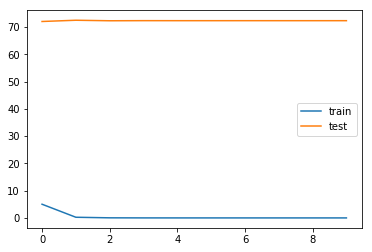

('learned w[:10]:', 
 [[ 0.66351265  0.4148293   0.139034    0.7056324   0.9513437   0.60462874
   -1.5091933  -0.28549913  0.50639105 -0.93982106]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [-0.3102827]
 <NDArray 1 @cpu(0)>)

In [3]:
train(0)

即便训练误差可以达到 $0.000000$，但是测试数据集上的误差很高。这是典型的过拟合现象。

观察学习的参数。事实上，大部分学到的参数的绝对值比真实参数的绝对值要大一些。

## 使用``Gluon``的正则化

下面我们重新初始化模型参数并在`Trainer`里设置一个`wd`参数。

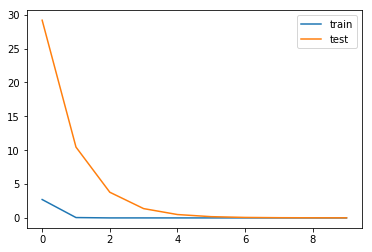

('learned w[:10]:', 
 [[ 0.00501012  0.00103364  0.01504096  0.00059534  0.00618694 -0.0042805
   -0.00211839  0.01688572 -0.0106975   0.00296203]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [0.00354912]
 <NDArray 1 @cpu(0)>)

In [4]:
train(5)

我们发现训练误差虽然有所提高，但测试数据集上的误差有所下降。过拟合现象得到缓解。
但打印出的学到的参数依然不是很理想，这主要是因为我们训练数据的样本相对维度来说太少。

## 结论

* 使用``Gluon``的`weight decay`参数可以很容易地使用正则化来应对过拟合问题。

## 练习

* 如何从字面正确理解`weight decay`的含义？它为何相当于$L_2$范式正则化？

**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/985)